In [1]:
%load_ext autoreload
%autoreload 2
import utils; utils.setup()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

import visualization
import data

In [3]:
interval = '15m'

from pathlib import Path
project_root = Path().resolve().parent
df = data.load_symbol('solusdt', dir=project_root, interval=interval)
df = data.set_interval(df, '15min')
# df = data.add_dayofweek_column(df)
# df = data.add_atr_column(df)
df

,open,high,low,close,volume,data_points
timestamp_nanos,,,,,,
2023-03-24 14:00:00,21.73,21.40,21.73,21.63,101849.76,4977
2023-03-24 14:15:00,21.64,21.52,21.67,21.60,46304.04,2033
2023-03-24 14:30:00,21.61,21.46,21.73,21.48,62293.18,2230
2023-03-24 14:45:00,21.48,21.44,21.55,21.45,31913.60,1481
2023-03-24 15:00:00,21.44,21.08,21.45,21.09,111469.65,5356
...,...,...,...,...,...,...
2023-12-31 22:45:00,102.46,100.00,102.49,100.53,171701.19,24995
2023-12-31 23:00:00,100.53,100.40,101.69,100.90,73191.15,9185
2023-12-31 23:15:00,100.91,99.78,101.07,100.72,116886.55,13322


In [25]:
periods = 64

close = df['close'].to_numpy()[:-periods]
close = close * np.ones((periods, len(close)))
close = close.T

rolling = {
    'high': (pd.DataFrame([window.to_list() for window in df['high'].rolling(periods)], index=df.index).dropna()[1:] - close) / close,
    'low':  (pd.DataFrame([window.to_list() for window in df['low'] .rolling(periods)], index=df.index).dropna()[1:] - close) / close,
}


In [26]:
what = 'high'
g = 0.02

predicate = (g < rolling[what]).any(axis=1)

high = rolling[what]
gain = high[predicate]
loss = high[predicate.apply(lambda x: not x)]
len(gain)


9997

Text(0.5, 1.0, 'min waiting period (looks like poison dist.)')

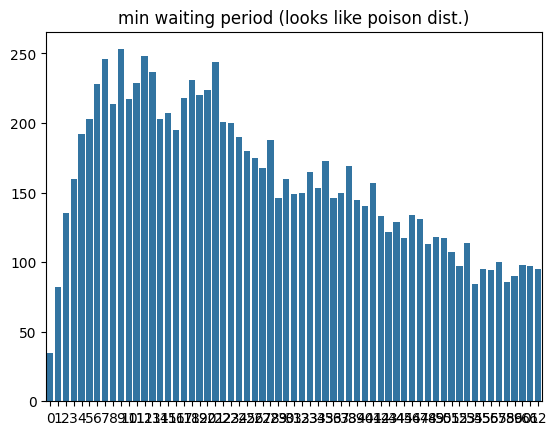

In [31]:
arr = (g < rolling[what]) * np.array([np.arange(periods) for _ in range(len(predicate))])
arr[arr == 0] = np.nan
holding_period, counts = np.unique(arr.min(axis=1).dropna().astype(int), return_counts=True)
axs = sns.barplot(counts)
axs.set_title('min waiting period (looks like poison dist.)')

Text(0.5, 1.0, 'hit rate of 9997 possible wins above g = 0.02 by waiting period')

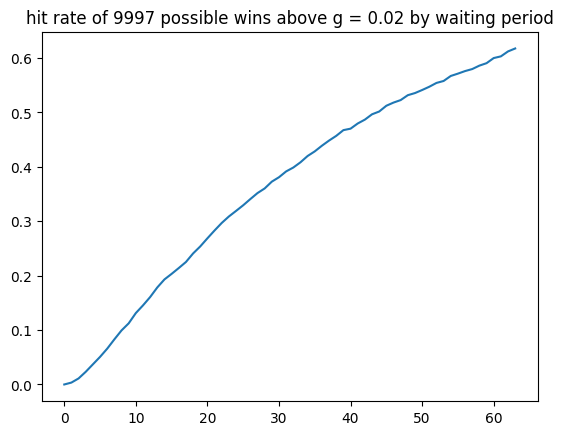

In [28]:
gain_len = len(gain)
gain_sum = (gain > g).sum(0)
axs = sns.lineplot(gain_sum / gain_len)
axs.set_title(f'hit rate of {gain_len} possible wins above g = {g} by waiting period')

Text(0.5, 1.0, 'waiting period for 9997 wins')

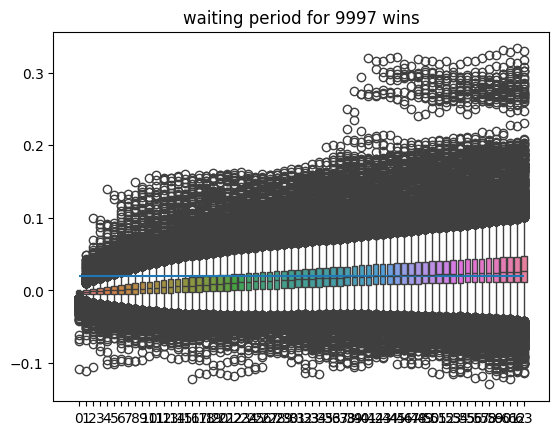

In [29]:
axs = sns.boxplot(gain)

axs.hlines(g, 0, periods - 1)
axs.set_title(f'waiting period for {gain_len} wins')